# 第六週: 中文文集的情緒分析2

**Author:** 劉岱宜<br>
**Date created:** 2021/10/01<br>
**Last modified:** 2021/10/01<br>
本週課程為「情緒分析2」，與情緒分析1不同，這次會使用中研院提供的CKIP自然語言處理工具包，但其中不像coreNLP有提供情緒分析到套件，所以在此介紹一款用於中文情緒分析的套件SnowNLP，是Courpus-base的情緒分析，不是使用情緒字典而是使用預訓練的情緒分析模型或演算法為整個文章給與一個情緒分數。情緒分析2的步驟會因所要分析之語言不同而有所差異，在這個Jupyter Notebook當中將會展示「中文」的情緒分析，並且搭配python程式碼進行講解。在後面的內容中會介紹CKIP、分析方法、SnowNLP

## 大綱
1. 套件說明
2. CKIP 介紹
    + 2.1 安裝CKIP
    + 2.2 利用CKIP進行自然語言處理
3. 文章抓取 & CKIP 標註
    + 3.1 用twitter api抓取資料
    + 3.2 將抓取結果用coreNLP進行處理
    + 3.3 探索分析 - NER
    + 3.4 探索分析 - POS
4. 利用SnowNLP進行情緒分析

## 1. 套件說明
下面列出在本次實作過程中我們所使用到的相關套件，在這個Jupyter Notebook當中我們將會簡單的展示這些套件的使用方式，關於各個套件的進階使用請同學參照其官網的說明。
- pandas: 一個資料分析的函式庫，提供了DataFrame等資料格式，與資料處理的函數。
- NLTK: 全名為Natural Language Tool Kit，自然語言處理工具。
- stanza: 使用CoreNLP的官方套件
- wordcloud: 文字雲繪圖工具。
- matplotlib: 繪圖工具。
- SnowNLP: SnowNLP是一個可以方便的處理中文文本內容的python類庫，是受到了TextBlob的啟發而寫的。SnowNLP主要功能包括斷詞、詞性標註、情緒分析、漢字轉拼音、繁體轉簡體、關鍵詞提取以及文本摘要等等。

In [ ]:
# 安裝會使用到的套件
# %pip install ckiptagger[tf,gdown] wordcloud 

In [1]:
# 確認當前工作目錄
%pwd

'/home/skypc785308/SMA_2021F/week6_sentiment_analysis2'

In [16]:

from ckiptagger import data_utils, construct_dictionary, WS, POS, NER
import configparser, re, os, io

from wordcloud import WordCloud, ImageColorGenerator
import tweepy as tw

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
from datetime import datetime, timedelta

## 2. CKIP 介紹
- 是中研院詞庫小組開發的中文自然語言處理套件，其斷詞效果比起`jieba`效果更好，並且提供性命名實體辨識、詞性標註、句法分析
- github: https://github.com/ckiplab/ckiptagger

### 2.1 CKIP安裝

In [5]:
data_utils.download_data_gdown("./") # gdrive-ckip # 下載ckip model

Downloading...
From: https://drive.google.com/uc?id=1efHsY16pxK0lBD2gYCgCTnv1Swstq771
To: /home/skypc785308/SMA_2021F/week6_sentiment_analysis2/data.zip
1.88GB [00:30, 62.5MB/s]


In [6]:
# To use CPU:
ws = WS("./data")
pos = POS("./data")
ner = NER("./data")

/usr/local/anaconda3/envs/test/lib/python3.6/site-packages/keras/layers/legacy_rnn/rnn_cell_impl.py:901: UserWarning: `tf.nn.rnn_cell.LSTMCell` is deprecated and will be removed in a future version. This class is equivalent as `tf.keras.layers.LSTMCell`, and will be replaced by that in Tensorflow 2.0.
  warnings.warn("`tf.nn.rnn_cell.LSTMCell` is deprecated and will be "
/usr/local/anaconda3/envs/test/lib/python3.6/site-packages/keras/engine/base_layer_v1.py:1684: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


### 2.2 利用CKIP進行自然語言處理
透過ckip這個套件可以對文集進行斷詞、命名實體辨識、詞性標記等處理
+ CKIP 標註任務
    + 斷詞（ws）
        + 可以設定自己的辭典
            + `recommend_dictionary` 推薦字典
            + `coerce_dictionary` 強制字典
    + 實體辨識（ner）
    + 詞性標註（pos）
        + 名詞對應: https://ckip.iis.sinica.edu.tw/service/corenlp/

In [7]:
word_to_weight = {
    "魔法覺醒": 1,
    "睽違已久": 2,
}
dictionary1 = construct_dictionary(word_to_weight)
print(dictionary1)

[(4, {'魔法覺醒': 1.0, '睽違已久': 2.0})]


In [8]:
sentence_list = [
    "哈利波特魔法覺醒是一個中國網易代理的粉絲睽違已久的手遊app",
     "很多人滿心期待這款英國出品的遊戲，卻又害怕受傷害"
]

word_sentence_list = ws(sentence_list, coerce_dictionary = dictionary1)  # 斷詞
pos_sentence_list = pos(word_sentence_list)
entity_sentence_list = ner(word_sentence_list, pos_sentence_list)

def print_word_pos_sentence(word_sentence, pos_sentence):
    assert len(word_sentence) == len(pos_sentence)
    for word, pos in zip(word_sentence, pos_sentence):
        print(f"{word}({pos})", end="\u3000")
    print()
    return
    
for i, sentence in enumerate(sentence_list):
    print()
    print(f"sentence {i}: {sentence}")
    print("\nPOS: ", end="\u3000")
    print_word_pos_sentence(word_sentence_list[i],  pos_sentence_list[i])
    print("\nNER: ")
    for entity in sorted(entity_sentence_list[i]):
        print(entity)


sentence 0: 哈利波特魔法覺醒是一個中國網易代理的粉絲睽違已久的手遊app

POS: 　哈利波特(Nb)　魔法覺醒(Nb)　是(SHI)　一(Neu)　個(Nf)　中國(Nc)　網易(Nb)　代理(VC)　的(DE)　粉絲(Na)　睽違已久(VH)　的(DE)　手遊(Na)　app(FW)　

NER: 
(11, 13, 'NORP', '中國')
(13, 15, 'ORG', '網易')

sentence 1: 很多人滿心期待這款英國出品的遊戲，卻又害怕受傷害

POS: 　很多(Neqa)　人(Na)　滿心(D)　期待(VK)　這(Nep)　款(Nf)　英國(Nc)　出品(VC)　的(DE)　遊戲(Na)　，(COMMACATEGORY)　卻(D)　又(D)　害怕(VK)　受(VJ)　傷害(Na)　

NER: 
(9, 11, 'GPE', '英國')


## 3. 文章抓取 & CKIP 標註

### 3.1 用twitter api抓取資料
資料來源:
+ twitter api 爬取貼文
+ 關鍵字:「哈利波特」、「 魔法覺醒」(637筆)
+ 時間: 2021-09-01 ~ 2021-09-20

1. 首先申請twitter 相關的 token secret https://developer.twitter.com/en/docs/tutorials/step-by-step-guide-to-making-your-first-request-to-the-twitter-api-v2
2. 申請完之後token會在 Developer Portal > project & Apps > Keys and tokens

In [17]:

# API Key and Secret
CONSUMER_KEY = 'eNMQchTiHN7WjnQksfvHAJgA9'
CONSUMER_SECRET = 'MS5xRYuRUERepYaSeABsNjREf9Fvthr7ihsrtswYqBm51GTvPB'
# Access Token and Secret
OAUTH_TOKEN = '1193849843279511552-dXvAjOpZjXFI5BTDLZBW5Ljq551OG1'
OAUTH_TOKEN_SECRET = 'wWGtd0HmThSgHh5Gdi1VDrVRATm1sHJpMi3gcFBC1qxGT'

In [18]:
# 開通api權限
auth = tw.OAuthHandler(CONSUMER_KEY, CONSUMER_SECRET)
auth.set_access_token(OAUTH_TOKEN, OAUTH_TOKEN_SECRET)
api = tw.API(auth, wait_on_rate_limit=True)

In [19]:
# 將抓到的貼文轉為datafranme
def twitter_table(keyword, from_date,end_date, lang_type,limit):
    
    # 定義 search api 參數
    all_tweets = tw.Cursor(
                        api.search,
                        q=keyword,
                        lang=lang_type,
                        since=from_date,
                        until=end_date
                    ).items(limit)    
    
    # 定義tweet attribute
    tweets_list= [[tweet.created_at, tweet.id, tweet.user.screen_name,
               tweet.user.name, tweet.text, tweet.favorite_count, tweet.retweet_count,tweet.source
              ] for tweet in all_tweets]
    
    # 定義欄位名稱
    tweet_table = pd.DataFrame(data=tweets_list, 
                        columns=['created_at','status_id', 'user_id',
                                 'user_name', 'text','favourites', 'retweet','source'])
        
    tweet_table = tweet_table[['created_at','status_id', 'user_id',
                               'user_name', 'text','favourites', 'retweet','source']]
    
    return tweet_table

+ 設定爬文抓取條件
    + 時間為 2021-09-01 ~ 2021-09-20 （2021-09-09 遊戲發布）
    + 關鍵字為 「哈利波特」 或 「魔法覺醒」，去掉重複推文的文章
    + 更多 query 規則: https://developer.twitter.com/en/docs/twitter-api/tweets/search/integrate/build-a-query
    + lang 可以抓取的語言列表: https://developer.twitter.com/en/docs/twitter-for-websites/supported-languages

In [20]:
# 抓到 330 筆資料
keyword = "哈利波特 OR 魔法覺醒 -filter:retweets"
from_date = "2021-09-01"  
end_date = "2021-09-20"  
lang_type = "zh-cn" 
limit = 2000

In [21]:
# 透過twitter api抓取堆文，會需要等一會
# tweets_df = twitter_table(keyword, from_date,end_date, lang_type,limit)
# tweets_df

In [24]:
# 將推特文章存成csv
# tweets_df.to_csv(r'source/zh/tweets_HarryPotter_zhcn.csv', index = False)

In [29]:
# 讀取已經抓取完成的推文
tweets_df = pd.read_csv("raw_data/zh/tweets_HarryPotter_zhcn.csv")

### 3.2 將抓取結果用coreNLP進行處理
我們已經介紹過coreNLP的使用方式，也抓取到twitter上的資料，來實做一次將該資料使用coreNLP進行自然語言處理

(1) 定義文字清理的相關function

In [30]:
def Segmentation_Core(data, tokenizer):
    # 將所有的斷行字元配上 escape 以防失效
    regexPattern = '|'.join(map(re.escape, tokenizer))
    output_list = re.split(regexPattern, data)
    # 過濾空白行
    output_list = list(filter(None, output_list))
    return output_list

def Sentence_Segmentation(article, keep_digits=False, keep_alphabets=False):
    """ Sentence_Segmentation function 用於執行中文斷行任務

    順序如下：
    1. 去除(\\n)
    2. 去除特殊符號字元
    3. 保留數字
    4. 依照斷句字元進行斷句全形的分號、逗號、句號、問號以及驚嘆號
    5. 避免空白斷句結果

    Args:
        article(string): 欲斷行之文章內容
        keep_digits(Boolean): 決定是否保留數字於斷行後的結果
        keep_alphabets(Boolean): 決定是否保留字母於斷行後的結果
    Returns:
        List [] 每個 element 就是一行
    """
    final_res = []
    sepical_symbols = r'[.＂<>:《》+\-=#$%&()*@＃＄％＆＇\(\)\[\]\{\}（）＊＋－／：\
    ＜＝＞＠［＼］＾＿｀｛｜｝～｟｠｢｣､、〃》「」『』【】〔〕〖〗〘〙〚〛〜〝〞〟〰〾〿–—‘’‛“”„‟…‧﹏★→─]+'
    segmentation_used_note = (";", "；", "！", "!", "？", "?", "。")
    
#     paragraphs = list(filter(None, article.split("\n")))
    paragraphs = list(filter(lambda x: re.sub(r'\s+','', x), article.split("\n")))
#     print(len(paragraphs))
#     print(paragraphs)
    result = []
    for paragraph in paragraphs:

        clean_paragraph = paragraph
        try:
            if not keep_digits:
                clean_paragraph = re.sub(r'\d*\.?\d+','', clean_paragraph) #remove space & digits
            if not keep_alphabets:
                clean_paragraph = re.sub('[a-zA-Z]+', '', clean_paragraph)
            
            clean_paragraph = re.sub(r'[\s]+','', clean_paragraph) #remove space
            
            clean_paragraph = re.sub(sepical_symbols,'',clean_paragraph)
            
        except:
            _logger.info("error")
            return "error"
        
        res = Segmentation_Core(clean_paragraph, segmentation_used_note)
        result.append(res)
    
    return result

(2) CKIP 設定
+ 讀入自定義的哈利波特辭典
    + 到搜狗字典下載需要的檔案，通常會是 `.scel` 檔
    + 把 `.scel` 轉 `.txt`:https://www.toolnb.com/tools-lang-zh-TW/scelto.html
    + 簡體轉繁體: https://txtconv.arpuli.com/

In [31]:
# 自定義辭典
with open('dict/harry.txt') as f:
    lines = f.read().splitlines()

dict_harry = {k: 1 for v, k in enumerate(lines)}
dictionary2 = construct_dictionary(dict_harry)
print(dictionary2)

[(2, {'西追': 1.0, '阿瑟': 1.0, '艾博': 1.0, '傲羅': 1.0, '巴蒂': 1.0, '白鮮': 1.0, '斑斑': 1.0, '貝恩': 1.0, '貝爾': 1.0, '彼得': 1.0, '比爾': 1.0, '波爾': 1.0, '伯莎': 1.0, '波特': 1.0, '布朗': 1.0, '草藥': 1.0, '查理': 1.0, '長袍': 1.0, '達力': 1.0, '德瑞': 1.0, '迪安': 1.0, '地精': 1.0, '洞聽': 1.0, '斗篷': 1.0, '多比': 1.0, '厄尼': 1.0, '飛馬': 1.0, '飛行': 1.0, '糞石': 1.0, '分體': 1.0, '鳳凰': 1.0, '福吉': 1.0, '弗農': 1.0, '芙蓉': 1.0, '附身': 1.0, '坩堝': 1.0, '高爾': 1.0, '光輪': 1.0, '哈利': 1.0, '哈珀': 1.0, '海格': 1.0, '漢娜': 1.0, '赫敏': 1.0, '黑湖': 1.0, '魂器': 1.0, '級長': 1.0, '加隆': 1.0, '禁林': 1.0, '金妮': 1.0, '巨怪': 1.0, '巨人': 1.0, '凱蒂': 1.0, '科林': 1.0, '苦艾': 1.0, '窺鏡': 1.0, '拉環': 1.0, '狼人': 1.0, '勒梅': 1.0, '莉莉': 1.0, '麗塔': 1.0, '琳妮': 1.0, '陋居': 1.0, '魯伯': 1.0, '盧多': 1.0, '盧娜': 1.0, '盧平': 1.0, '路威': 1.0, '羅恩': 1.0, '羅傑': 1.0, '羅琳': 1.0, '羅南': 1.0, '麻瓜': 1.0, '馬人': 1.0, '麥格': 1.0, '媚娃': 1.0, '密室': 1.0, '莫恩': 1.0, '莫麗': 1.0, '魔藥': 1.0, '魔杖': 1.0, '魔咒': 1.0, '穆迪': 1.0, '牡鹿': 1.0, '納特': 1.0, '納威': 1.0, '納維': 1.0, '尼可': 1.0, '諾伯': 1.0, '諾特': 1.0, '潘西': 1.0, '佩妮'

In [44]:
def get_pos(post_id, word_sentence, pos_sentence):
    tokens = []
#     print("\nPOS: ", end="\u3000")
    assert len(word_sentence) == len(pos_sentence)
    for word, pos in zip(word_sentence, pos_sentence): # token level
        tokens.append([post_id,word,pos]) 
#         print(f"{word}({pos})", end="\u3000")
    return tokens

def get_ner(post_id, entity_sentence):
    entities = []
#     print("\nNER:___________ ")
    for entity in sorted(entity_sentence): # token level
        entities.append([post_id, entity[3],entity[2]]) 
    return entities

def get_nlp_result(data_df):
    start = time.time()

    pos_list = []
    entity_list = []
    sentence_list = []
    
    for index, row in data_df.iterrows(): # document level    
#         print(f"\ndocument {index}") 

        # clean data
        result = [] 
        tmp = Sentence_Segmentation(row['text']) 
        flat_list = [item for sublist in tmp for item in sublist]

        # ckip
        word_sentence_list = ws(flat_list, coerce_dictionary = dictionary2) # set dictionary 
        pos_sentence_list = pos(word_sentence_list)
        entity_sentence_list = ner(word_sentence_list, pos_sentence_list)

        for i, sentence in enumerate(flat_list): # sentence level
#             print(f"sentence {i}: {sentence}")
            sentence_list.append([row['status_id'],sentence])            
            temp_tokens = get_pos(row['status_id'],word_sentence_list[i],  pos_sentence_list[i])
            temp_entites = get_ner(row['status_id'],entity_sentence_list[i])

            pos_list.append(temp_tokens)
            if len(temp_entites) != 0:
                entity_list.append(temp_entites)
            
    pos_flat = [item for sublist in pos_list for item in sublist]
    entity_flat = [item for sublist in entity_list for item in sublist]

    pos_table = pd.DataFrame(data=pos_flat, 
                    columns=['status_id','word','pos'])        
    
    entity_table = pd.DataFrame(data=entity_flat, 
                        columns=['status_id','word','ner']) 

    sentence_table = pd.DataFrame(data=sentence_list, 
                    columns=['status_id','sentence']) 

    end = time.time()
    print("time costing: {}".format(end - start))

    return pos_table, entity_table, sentence_table

In [45]:

pos_table, entity_table, sentence_table = get_nlp_result(tweets_df)
# time costing: 43.8019802570343

time costing: 42.01198863983154


In [32]:
# 將推特文章存成csv

# pos_table.to_csv(r'source/zh/pos_table_HarryPotter_zhcn.csv', index = False)
# entity_table.to_csv(r'source/zh/entity_table_HarryPotter_zhcn.csv', index = False)
# sentence_table.to_csv(r'source/zh/sentence_table_HarryPotter_zhcn.csv', index = False)

+ 欄位名稱介紹
    + pos_table 欄位:
        + status_id : tweets 貼文id
        + word: 原始斷詞
        + pos : part-of-speech,詞性
    + entity_table 欄位:
        + status_id : tweets 貼文id
        + word: 原始斷詞
        + ner: 命名實體
    + sentence_table 欄位:
        + status_id : tweets 貼文id
        + text: 原始斷句

In [46]:
pos_table.head(5) # word pos 列表

,status_id,word,pos
0,1439738694584311810,_,FW
1,1439738694584311810,哈利波特,Nb
2,1439738694584311810,，,COMMACATEGORY
3,1439738694584311810,雙人,Na
4,1439738694584311810,組隊,VA


In [47]:
entity_table.head(5) # word entity 列表

,status_id,word,ner
0,1439738694584311810,哈利波特,PERSON
1,1439738139346567170,湯姆,PERSON
2,1439738139346567170,艾瑪,PERSON
3,1439738139346567170,哈利波特片場,FAC
4,1439738139346567170,馬份,PERSON


In [48]:
# 檢查筆數正不正確
print(f"total posts numbers: {len(pos_table['status_id'].unique())}") # 636篇文
print(f"posts have NER: {len(entity_table['status_id'].unique())}") # 440篇有抓到ner

total posts numbers: 636
posts have NER: 440


# 3.3 探索分析 - NER

將剛才分析的資料匯入

In [51]:
# 讀取已經執行完畢的結果
pos_table = pd.read_csv("raw_data/zh/pos_table_HarryPotter_zhcn.csv") 
entity_table = pd.read_csv("raw_data/zh/entity_table_HarryPotter_zhcn.csv") 

### NER 種類分析
查看標註這個文集後辨識出哪一些實體種類

In [52]:
entity_table['ner'].unique()

array(['PERSON', 'FAC', 'CARDINAL', 'TIME', 'DATE', 'ORG', 'PRODUCT',
       'LANGUAGE', 'ORDINAL', 'GPE', 'NORP', 'WORK_OF_ART', 'EVENT'],
      dtype=object)

In [53]:
ner_count = entity_table.groupby(['ner'])['ner'] \
                             .count() \
                             .reset_index(name='count') \
                             .sort_values(['count'], ascending=False) \
                             .head(12)
ner_count

,ner,count
9,PERSON,434
1,DATE,93
10,PRODUCT,63
0,CARDINAL,41
8,ORG,33
4,GPE,31
7,ORDINAL,31
11,TIME,22
6,NORP,19
3,FAC,12


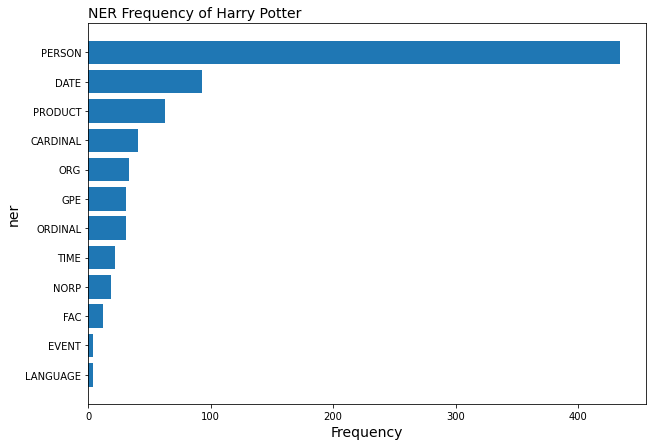

In [55]:
ner = ner_count['ner']
count = ner_count['count']

fig, ax = plt.subplots(figsize =(10, 7))
ax.barh(ner, count)
ax.invert_yaxis()
ax.set_title('NER Frequency of Harry Potter',loc ='left', size = 14)
ax.set_ylabel('ner', size = 14)
ax.set_xlabel('Frequency', size = 14)
fig.show()

### 涉及到的人名(PERSON)

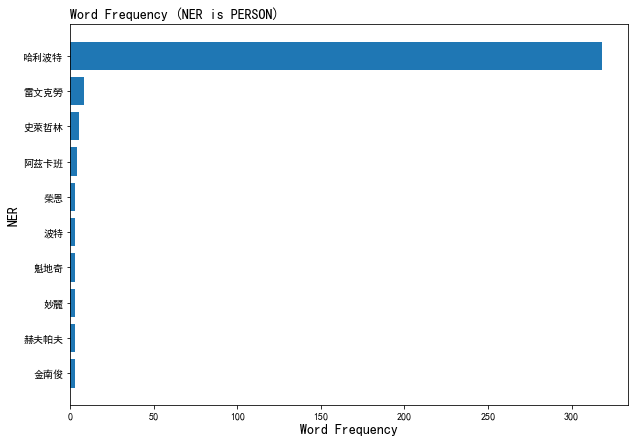

In [57]:
# 篩選ner為名詞的資料
l_noun = ["PERSON"]
PERSON = entity_table[entity_table.ner.isin(l_noun)]

# # 計算每個名詞提到的次數，選出前10個
ner_count = PERSON.groupby('word')['word'].agg(['count'])
ner_count = ner_count.sort_values(['count'],ascending=False)['count'].nlargest(10).reset_index()
ner_count

# 設定中文字形
plt.rcParams['font.sans-serif'] = ['SimHei'] 
word = ner_count['word']
count = ner_count['count']

fig, ax = plt.subplots(figsize =(10, 7))
ax.barh(word, count)
ax.invert_yaxis()
ax.set_title('Word Frequency (NER is PERSON)',loc ='left', size = 14)
ax.set_ylabel('NER', size = 14)
ax.set_xlabel('Word Frequency', size = 14)
fig.show()

看一下含特定關鍵字的貼文內容

In [58]:
keyword_list = ['雷文克勞','史萊哲林']
select = sentence_table[sentence_table['sentence'].str.contains('|'.join(keyword_list),regex=True)]
select.head(10)

,status_id,sentence
32,1439658050118316033,又測了兩次都是雷文克勞越了解哈利波特世界就越不獾院了餒，怎麼會這樣還是是我變了
129,1439535684394520578,好ㄌ啦雷文克勞真難相處
180,1439461184730763264,結論是🦈🔍赫夫帕夫🐙雷文克勞🐔💀葛來分多
476,1438840222100324352,問下，哈利波特應該去雷文克勞還是葛萊芬多，當然也考慮赫夫帕夫
624,1438558623370649606,邊工作邊想我要去哪個學院才好呢雷文克勞很棒但代表動物卻是老鷹💔
750,1438385633148297216,比較想加入雷文克勞或赫夫帕夫
751,1438385633148297216,剛剛別的單位的同事跑來跟我們單位的同事交流一下哈利波特，我順便問了他是哪個學院的，他說他是雷文克勞
752,1438385633148297216,他選雷文克勞的理由衣服好看
772,1438360019246874630,如果有朋朋玩哈利波特手遊的話，我是史萊哲林的，請當我的室友好嗎
877,1438125842983370756,哈利波特游戲裡在史萊哲林的休息室有一枚舊舊的徽章上面寫著波特臭大糞


大部分為角色名稱，「哈利波特」是主角也是遊戲名，被提及的次數最多，其次「榮恩」和「妙麗」被提及的頻率差不多；學院部分「雷文克勞」是許多人考慮熱門選項，且用戶普遍對「史萊哲林」的學院設定感興趣；另外遊戲中「阿茲卡班」的懲罰機制也是用戶討論重點。

### 涉及到的組織(ORG)

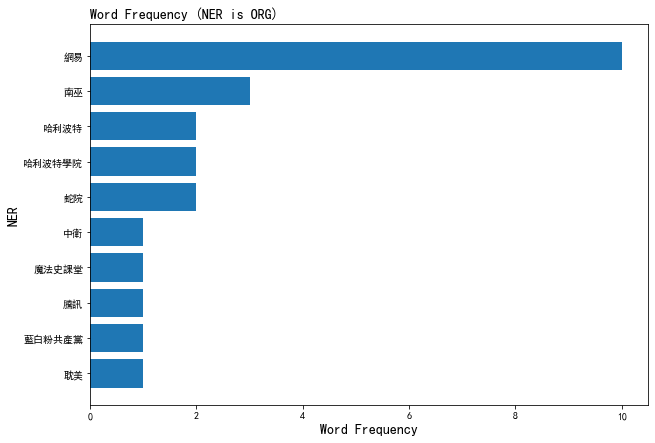

In [59]:
# 篩選ner為名詞的資料
l_noun = ["ORG"]
ORG = entity_table[entity_table.ner.isin(l_noun)]

# # 計算每個名詞提到的次數，選出前10個
ner_count = ORG.groupby('word')['word'].agg(['count'])
ner_count = ner_count.sort_values(['count'],ascending=False)['count'].nlargest(10).reset_index()
ner_count

# 設定中文字形
plt.rcParams['font.sans-serif'] = ['SimHei'] 
word = ner_count['word']
count = ner_count['count']

fig, ax = plt.subplots(figsize =(10, 7))
ax.barh(word, count)
ax.invert_yaxis()
ax.set_title('Word Frequency (NER is ORG)',loc ='left', size = 14)
ax.set_ylabel('NER', size = 14)
ax.set_xlabel('Word Frequency', size = 14)
fig.show()

部分網友因此款遊戲為「網易」出品而對遊戲的隱私性產生疑慮。

### 涉及到的民族、宗教、政治團體(NORP)

/usr/local/anaconda3/envs/test/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 12640 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/anaconda3/envs/test/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 12640 missing from current font.
  font.set_text(s, 0, flags=flags)


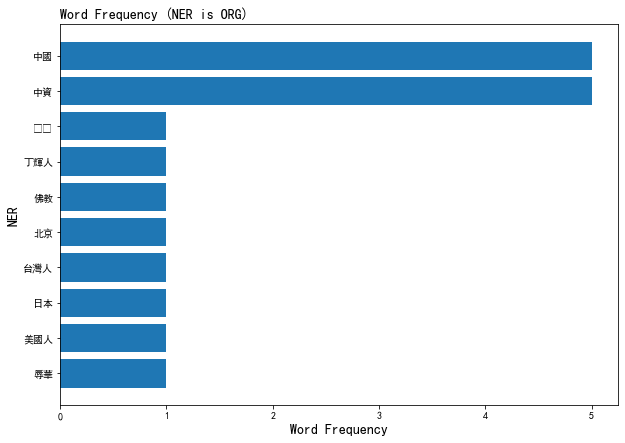

In [60]:
# 篩選ner為名詞的資料
l_noun = ["NORP"]
NORP = entity_table[entity_table.ner.isin(l_noun)]

# # 計算每個名詞提到的次數，選出前10個
ner_count = NORP.groupby('word')['word'].agg(['count'])
ner_count = ner_count.sort_values(['count'],ascending=False)['count'].nlargest(10).reset_index()
ner_count

# 設定中文字形
plt.rcParams['font.sans-serif'] = ['SimHei'] 
word = ner_count['word']
count = ner_count['count']

fig, ax = plt.subplots(figsize =(10, 7))
ax.barh(word, count)
ax.invert_yaxis()
ax.set_title('Word Frequency (NER is ORG)',loc ='left', size = 14)
ax.set_ylabel('NER', size = 14)
ax.set_xlabel('Word Frequency', size = 14)
fig.show()

In [61]:
keyword_list = ['中國','中資','北京']
sentence_table[sentence_table['sentence'].str.contains('|'.join(keyword_list),regex=True)]

,status_id,sentence
89,1439590611259064321,北京终于有哈利波特城堡啦///
232,1439282239364235267,雖然是中國的遊戲公司😢
252,1439268487797477377,不也是中資遊戲嗎
534,1438771788767383552,它是中國代理的哦
619,1438561043337265153,不管玩網易還是米哈游的中國遊戲，都不好意思跟身邊的人說，不過我個人倒不會對與中國來往有多麼大...
799,1438308622107230208,👾中國哈利波特手遊不能取台灣，網友出招反制
821,1438207911558221824,北京环球影城北京环球哈利波特///复制此链接，打开音搜索，直接观看视频
870,1438131770193371151,👾中國哈利波特手遊不能取台灣，網友出招反制
896,1438113445312827393,只可惜是中國做的就是了
927,1438078062386548739,👾中國哈利波特手遊不能取台灣，網友出招反制


承接ORG觀察到的高頻字詞，部分網友因魔法覺醒為中資而拒絕下載，也擔憂「中共」當局未來會將強審查力道，因「香港人」目前也列為敏感詞。

## 3.4 探索分析 - POS

### POS 種類分析
查看辨識出哪幾種POS

In [62]:
pos_table['pos'].unique()

array(['FW', 'Nb', 'COMMACATEGORY', 'Na', 'VA', 'T', 'Nh', 'P', 'VE',
       'Nd', 'Nc', 'D', 'VK', 'I', 'Ng', 'VJ', 'VH', 'DE', 'Cbb', 'Neu',
       'V_2', 'VL', 'Nep', 'Nf', 'VCL', 'VG', 'VC', 'Di', 'Dfa', 'Neqa',
       'SHI', 'VHC', 'Ncd', 'Dk', 'Nes', 'A', 'Caa', 'VF', 'Dfb', 'Neqb',
       'Da', 'Cab', 'VD', 'VI', 'PERIODCATEGORY', 'DM',
       'PARENTHESISCATEGORY', 'Nv', 'VB', 'Cba', 'COLONCATEGORY', 'VAC'],
      dtype=object)

看看除了標點符號，大部分的POS都是哪一類

In [63]:
pos_filter = pos_table[~pos_table.pos.isin(['COMMACATEGORY', 'PARENTHESISCATEGORY', 'PERIODCATEGORY', 'COLONCATEGORY'])]

pos_count = pos_filter.groupby(['pos'])['pos'] \
                             .count() \
                             .reset_index(name='count') \
                             .sort_values(['count'], ascending=False) \
                             .head(12)
pos_count

,pos,count
15,Na,2403
5,D,1607
13,FW,1147
35,VC,1145
16,Nb,1096
41,VH,895
27,Nh,713
6,DE,702
29,P,451
32,VA,374


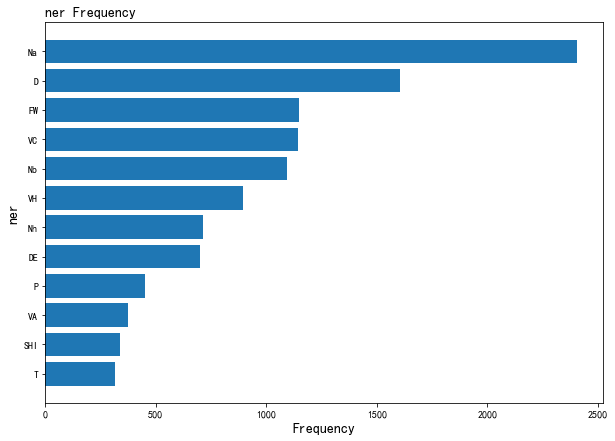

In [66]:
pos = pos_count['pos']
count = pos_count['count']

fig, ax = plt.subplots(figsize =(10, 7))
ax.barh(pos, count)
ax.invert_yaxis()
ax.set_title('ner Frequency',loc ='left', size = 14)
ax.set_ylabel('ner', size = 14)
ax.set_xlabel('Frequency', size = 14)
fig.show()

#### POS 詞性列表: 
+ 中研院列表: https://ckip.iis.sinica.edu.tw/service/corenlp/
    + Na: 普通名詞
    + D: 副詞
    + VC: 動作及物動詞
    + Nb: 專有名詞
    + FW: 外文
    + VH: 狀態不及物動詞
    + Nh: 代名詞
    + DE: 的之得地
    + P: 介詞
    + VA: 動作不及物動詞
    + T: 語助詞
    + SHI: 是

### 涉及到的名詞(Na)
+ 我們可以找出談論魔法覺醒時大部分討論到的專有名詞，探索大家的關注焦點。
+ 名詞可以分為「Na: 普通名詞」、「Nb: 專有名詞」等

In [67]:
# 篩選pos為名詞的資料
l_noun = ["Nb"] #,"Na"
noun = pos_table[pos_table.pos.isin(l_noun)]

# # 計算每個名詞提到的次數，選出前13個
noun_count = noun.groupby('word')['word'].agg(['count'])
noun_count = noun_count.sort_values(['count'],ascending=False)['count'].nlargest(15).reset_index()
noun_count

,word,count
0,哈利波特,667
1,游戏,31
2,哈利,20
3,伏地魔,10
4,波特,10
5,霍格沃兹,9
6,雷文克勞,9
7,魔宠传奇,7
8,主题元,7
9,網易,7


In [68]:
# 另外一種寫法
noun_count = noun[['word']].groupby(['word'])['word'] \
                                         .count() \
                                         .reset_index(name='count') \
                                         .sort_values(['count'], ascending=False) \
                                         .head(15)
noun_count

,word,count
44,哈利波特,667
142,游戏,31
43,哈利,20
18,伏地魔,10
138,波特,10
233,霍格沃兹,9
231,雷文克勞,9
243,魔宠传奇,7
7,主题元,7
177,網易,7


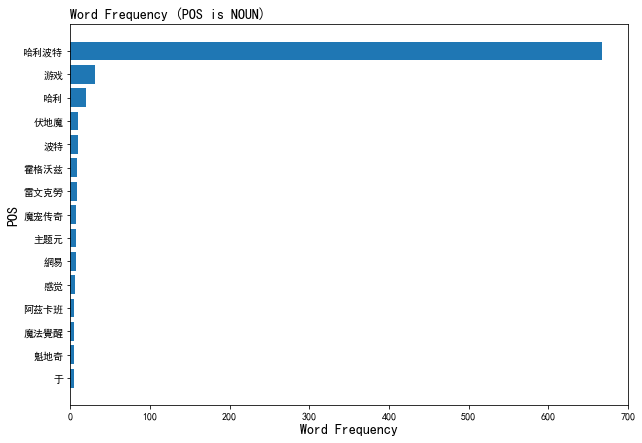

In [70]:
# 設定中文字形
plt.rcParams['font.sans-serif'] = ['SimHei'] 
word = noun_count['word']
count = noun_count['count']

fig, ax = plt.subplots(figsize =(10, 7))
ax.barh(word, count)
ax.invert_yaxis()
ax.set_title('Word Frequency (POS is NOUN)',loc ='left', size = 14)
ax.set_ylabel('POS', size = 14)
ax.set_xlabel('Word Frequency', size = 14)
fig.show()

可以看到魔法覺醒中，「伏地魔」也是討論度較高的角色，學院部分呼應上斷結論，「史萊哲林」和「雷文克勞」較熱門。

### 涉及到的動詞(VERB)
+ 我們可以找出談論魔法覺醒時大部分討論到的動詞，探索提到遊戲時的相關行為。
+ VC: 動作及物動詞、VH: 狀態不及物動詞、VA: 動作不及物動詞

In [71]:
l_verb = ["VH"] # ,"VH","VA"
verb = pos_table[pos_table.pos.isin(l_verb)] # 選取特定詞性
verb = verb[verb['word'].map(len) > 1] # 把長度為1的字去除掉

verb_count = verb[['word']].groupby(['word'])['word'] \
                                 .count() \
                                 .reset_index(name='count') \
                                 .sort_values(['count'], ascending=False) \
                                 .head(15)
verb_count

,word,count
94,好玩,24
348,魔法覺醒,22
239,直接,14
95,好看,12
288,觉醒,9
325,這樣,9
62,可愛,8
92,好好玩,7
61,可惜,7
20,不錯,7


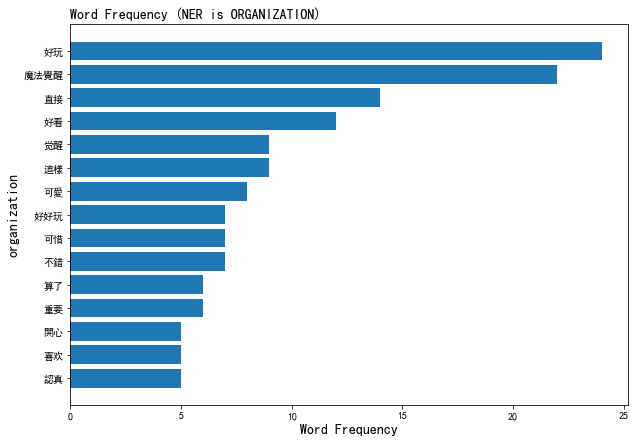

In [73]:
plt.rcParams['font.sans-serif'] = ['SimHei'] 
word = verb_count['word']
count = verb_count['count']

fig, ax = plt.subplots(figsize =(10, 7))
ax.barh(word, count)
ax.invert_yaxis()
ax.set_title('Word Frequency (NER is ORGANIZATION)',loc ='left', size = 14)
ax.set_ylabel('organization', size = 14)
ax.set_xlabel('Word Frequency', size = 14)
fig.show()

發現在貼文中的動詞，「好玩」佔了相當高的頻率，其他還有出現「好好玩」、「喜歡」等詞彙，可推測玩家對此款遊戲滿意度高。

In [74]:
# 看一下含特定關鍵字的貼文內容
keyword_list = ['好玩','好看','好好玩']
select = sentence_table[sentence_table['sentence'].str.contains('|'.join(keyword_list),regex=True)]
select.head(5)

,status_id,sentence
47,1439641122402304000,哈利波特手遊好好玩
114,1439551486132850691,哈利波特的中国风皮肤，这个白旗袍挺好看////
115,1439550831800434688,哈利波特好好玩我一直在打決鬥社
138,1439520111770046466,哈利波特我覺得最好看ㄉ地方是從阿茲卡班的逃犯結尾那邊開始時間回溯一直到後面
195,1439433415149772802,蛤，我覺得哈利波特還蠻好玩的，怎麼辦


## 4. 利用SnowNLP進行情緒分析

+ SnowNLP 針對中文設計，可以提取句子的情緒分類
+ 情緒值在 0~1之間，代表負面到正面
+ 官方github: https://github.com/isnowfy/snownlp

In [75]:
from snownlp import SnowNLP
s = SnowNLP('應該要開一個伺服器叫阿茲卡班')
s.sentiments # 範圍在 0~ 1之間 (負面~正面)

0.03430448367397765

將句子和日期合併，方便之後做分析

In [76]:
# sentence_table = pd.read_csv("source/zh/sentence_table_HarryPotter.csv") #匯資料
sentiment_date = pd.merge(sentence_table,tweets_df[['status_id','created_at','source']],on='status_id',how='left')
sentiment_date.head(3)

,status_id,sentence,created_at,source
0,1439738694584311810,_哈利波特，雙人組隊啊😂,2021-09-19 23:50:28,Twitter for iPhone
1,1439738139346567170,我跟我媽說湯姆跟艾瑪以前在哈利波特片場互相喜歡⋯,2021-09-19 23:48:16,Twitter for Android
2,1439738139346567170,欸你知道馬份跟妙麗戲外暗戀對方嗎,2021-09-19 23:48:16,Twitter for Android


In [77]:
def get_sentiment(sent):
    s = SnowNLP(sent)
    return s.sentiments

# 幫每句話加上情緒分數
sentiment_date['sentimentValue'] = sentiment_date.apply(lambda row : get_sentiment(row['sentence'],), axis = 1)
sentiment_date.head(5)

,status_id,sentence,created_at,source,sentimentValue
0,1439738694584311810,_哈利波特，雙人組隊啊😂,2021-09-19 23:50:28,Twitter for iPhone,0.997635
1,1439738139346567170,我跟我媽說湯姆跟艾瑪以前在哈利波特片場互相喜歡⋯,2021-09-19 23:48:16,Twitter for Android,0.986648
2,1439738139346567170,欸你知道馬份跟妙麗戲外暗戀對方嗎,2021-09-19 23:48:16,Twitter for Android,0.140883
3,1439738139346567170,👩‍👧真的假的我不知道欸,2021-09-19 23:48:16,Twitter for Android,0.303064
4,1439738139346567170,可是他們沒有在一起,2021-09-19 23:48:16,Twitter for Android,0.462185


In [78]:
# 看一下情緒的分布
sentiment_date['sentimentValue'].describe() # 2145句話

count    1522.000000
mean        0.702010
std         0.338112
min         0.000050
25%         0.446713
50%         0.885600
75%         0.995742
max         1.000000
Name: sentimentValue, dtype: float64

<AxesSubplot:>

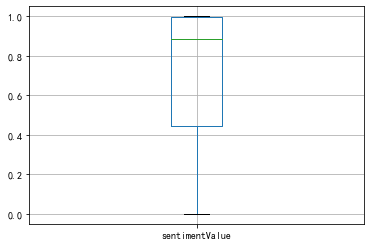

In [79]:
# 情緒分布的盒狀圖
boxplot = sentiment_date.boxplot(column=['sentimentValue'], showfliers=False)
boxplot

將每天的情緒分數取平均，並轉換時間格式為天

In [80]:
sentiment_date['created_at'] =  pd.to_datetime(sentiment_date['created_at']).dt.date
sentiment_count = sentiment_date.groupby(['created_at'])['sentimentValue'].mean().reset_index()
sentiment_count

,created_at,sentimentValue
0,2021-09-13,0.658437
1,2021-09-14,0.690771
2,2021-09-15,0.718597
3,2021-09-16,0.734480
4,2021-09-17,0.709320
5,2021-09-18,0.719035
6,2021-09-19,0.689233


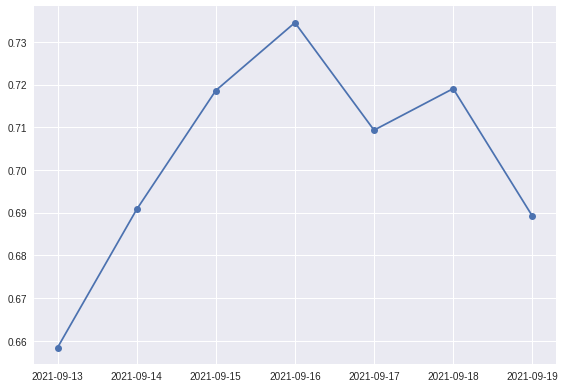

In [81]:
# 平均情緒分數時間趨勢
plt.style.use('seaborn')

dates = sentiment_count['created_at']
y = sentiment_count['sentimentValue']

plt.plot_date(dates, y, linestyle='solid')
plt.gcf().autofmt_xdate
plt.tight_layout()

plt.show()

## 不同用戶端情緒時間趨勢

In [82]:
# 篩出安卓和蘋果的用戶
sentiment_date = sentiment_date[sentiment_date['source'].isin(['Twitter for Android', 'Twitter for iPad'])]
# 算每天的情緒
source_count = sentiment_date.groupby(['created_at','source'])['sentimentValue'].mean().reset_index()
source_count

,created_at,source,sentimentValue
0,2021-09-13,Twitter for Android,0.564699
1,2021-09-13,Twitter for iPad,0.706528
2,2021-09-14,Twitter for Android,0.668570
3,2021-09-14,Twitter for iPad,0.576445
4,2021-09-15,Twitter for Android,0.702210
5,2021-09-15,Twitter for iPad,0.680091
6,2021-09-16,Twitter for Android,0.738287
7,2021-09-16,Twitter for iPad,0.732194
8,2021-09-17,Twitter for Android,0.688281
9,2021-09-17,Twitter for iPad,0.762021


In [83]:
# spread the column
source_pivot = source_count.pivot_table(index=['created_at'],columns='source',values='sentimentValue',fill_value=0).reset_index()
source_pivot

source,created_at,Twitter for Android,Twitter for iPad
0,2021-09-13,0.564699,0.706528
1,2021-09-14,0.668570,0.576445
2,2021-09-15,0.702210,0.680091
3,2021-09-16,0.738287,0.732194
4,2021-09-17,0.688281,0.762021
5,2021-09-18,0.698086,0.000000
6,2021-09-19,0.650384,0.661517


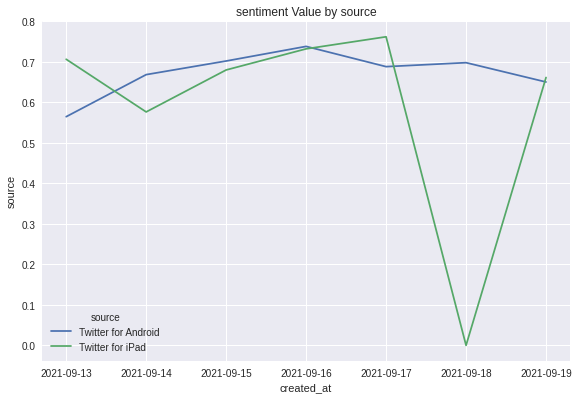

In [84]:
# 不同裝置情緒分數時間趨勢
plt.style.use('seaborn')

source_pivot.plot(x="created_at", y=["Twitter for Android", "Twitter for iPad"])
plt.gcf().autofmt_xdate
plt.tight_layout()

plt.ylabel('sentiment Value')
plt.ylabel('source')
plt.title('sentiment Value by source')

plt.show()

從上圖中發現大部分天數的情緒值都在0.5以上，偏向正面。只是9/15和9/16號的分數特別高，可以特別挑出來分析。

### 正面詞彙探索
從上圖中可以發現 9/15 和 9/17 的情緒特別高，我們把那兩天的正面句子挑出來看看他們都用甚麼詞，根據上面的盒狀圖我們可以發現，文中句子的情緒值大部分偏高，平均大概在0.8左右，臨界點取高一點，選情緒值選0.6以上的句子。

In [85]:
# 篩時間區間
startdate = pd.to_datetime("2021-09-15").date()
enddate = pd.to_datetime("2021-09-17").date()
filter_sentiment = sentiment_date[sentiment_date.created_at.between(startdate, enddate)]
filter_sentiment = filter_sentiment.loc[filter_sentiment['sentimentValue'] >= 0.6]

# 看一下正面句子都在討論甚麼
filter_sentiment

,status_id,sentence,created_at,source,sentimentValue
382,1438962753633456131,玩哈利波特后，今天是我睡得最早的一天,2021-09-17,Twitter for iPad,0.984097
402,1438930848062050306,收个哈利波特奴帮我打宝箱我老想不起来呜呜呜呜箱子都浪费了学年任务也没做社团活动也没做其实是想找老婆,2021-09-17,Twitter for Android,0.909156
403,1438920047523610631,哈利波特西弗勒斯·沈腾·斯内普,2021-09-17,Twitter for Android,0.999975
404,1438919777821642752,最近沉迷哈利波特,2021-09-17,Twitter for Android,0.996103
405,1438919777821642752,无心拍色图,2021-09-17,Twitter for Android,0.798607
...,...,...,...,...,...
1023,1437961668709924864,哈利波特吗,2021-09-15,Twitter for Android,0.994999
1027,1437949068362194944,吃完宵來一場哈利波特///,2021-09-15,Twitter for Android,0.987158
1028,1437939420338933760,來啦一起肝哈利波特坑,2021-09-15,Twitter for Android,0.989400
1029,1437939420338933760,香的,2021-09-15,Twitter for Android,0.649485


In [86]:
# 把時間分數和之前斷詞的token table做 join
positive_words = pd.merge(filter_sentiment,pos_table,on='status_id',how='left')
positive_words = positive_words[['status_id','sentimentValue','word']]
positive_words.head(5)

,status_id,sentimentValue,word
0,1438962753633456131,0.984097,玩
1,1438962753633456131,0.984097,哈利波特
2,1438962753633456131,0.984097,后
3,1438962753633456131,0.984097,，
4,1438962753633456131,0.984097,今天


In [87]:
# 篩選只有單個字元的結果
positive_words = positive_words[positive_words.apply(lambda x: len(x['word'])>1, axis=1)]

### 正面詞彙文字雲

In [88]:
# 自定停用字
with open('dict/stop_words.txt') as f:
    stop_words = f.read().splitlines()

print(stop_words)

[',', '?', '、', '。', '“', '”', '《', '》', '！', '，', '：', '；', '？', '再', '本來', '是不是', '一個', '這種', '人民', '末##末', '啊', '阿', '哎', '哎呀', '哎喲', '唉', '我', '我們', '按', '按照', '依照', '吧', '吧噠', '把', '罷了', '被', '本', '本著', '比', '比方', '比如', '鄙人', '彼', '彼此', '邊', '別', '別的', '別說', '並', '並且', '不比', '不成', '不單', '不但', '不獨', '不管', '不光', '不過', '不僅', '不拘', '不論', '不怕', '不然', '不如', '不特', '不惟', '不問', '不只', '朝', '朝著', '趁', '趁著', '乘', '沖', '除', '除此之外', '除非', '除了', '此', '此間', '此外', '從', '從而', '打', '待', '但', '但是', '當', '當著', '到', '得', '的', '的話', '等', '等等', '地', '第', '叮咚', '對', '對於', '多', '多少', '而', '而況', '而且', '而是', '而外', '而言', '而已', '爾後', '反過來', '反過來說', '反之', '非但', '非徒', '否則', '嘎', '嘎登', '該', '趕', '個', '各', '各個', '各位', '各種', '各自', '給', '根據', '跟', '故', '故此', '固然', '關於', '管', '歸', '果然', '果真', '過', '哈', '哈哈', '呵', '和', '何', '何處', '何況', '何時', '嘿', '哼', '哼唷', '呼哧', '乎', '嘩', '還是', '還有', '換句話說', '換言之', '或', '或是', '或者', '極了', '及', '及其', '及至', '即', '即便', '即或', '即令', '即若', '即使', '幾', '幾時', '己', '既', '既然', '既是', '繼而', '加之', 

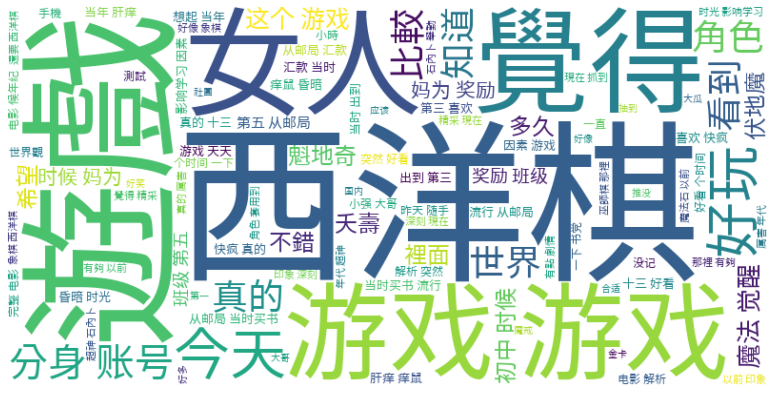

In [90]:


# 匯入自訂的 stop words (預設只有英文的)
stop_words_pos = stop_words
stop_words_pos.extend(('哈利波特','魔法覺醒','緩緩','綻放','最近'))
stop_words_pos = set(stop_words_pos)

# 設定中文字形
font_path = 'TaipeiSansTCBeta-Regular.ttf'

# 可以設定字型大小和背景顏色
wordcloud = WordCloud(
                stopwords=stop_words_pos,font_path=font_path,width=800, height = 400, max_words=100, background_color="white")

wordcloud.generate(' '.join(positive_words['word']))
# Display the generated image:
plt.figure(figsize = (14,7))
plt.imshow(wordcloud, interpolation="bilinear")

plt.axis("off")
plt.show()

在正面情緒的句子中，「西洋棋」關卡討論度高，也有部分貼文是在討論遊戲中的「角色」設定，也出現比較直接的情緒字「喜歡」、「好看」，或是蒐集遊戲中的「獎勵」等等。

### 負面詞彙探索
從上圖中可以發現 9/13,9/14 的情緒特別低，我們把那天的負面句子挑出來看看他們都用甚麼詞，根據上面的盒狀圖，我們選取情緒值小於0.5的句子。

In [91]:
# 篩時間區間
# sentiment_date.loc[sentiment_date.to_datetime(['2021-09-17', '2010-01-04'])]

date1 = pd.to_datetime('2021-09-13').date()
date2 = pd.to_datetime("2021-09-14").date()
filter_sentiment = sentiment_date[sentiment_date.created_at.isin([date1,date2])]
filter_sentiment = filter_sentiment.loc[filter_sentiment['sentimentValue'] < 0.5]

# 看一下負面句子都在討論甚麼
filter_sentiment.head(50)

,status_id,sentence,created_at,source,sentimentValue
1037,1437898667361333248,但該打的手槍還是要打的咦,2021-09-14,Twitter for Android,0.431861
1038,1437898667361333248,///,2021-09-14,Twitter for Android,0.250000
1041,1437870373761019904,我以為我們這個年紀的童年至少也會聽過如果是現在的小朋友倒是有可能🥺,2021-09-14,Twitter for Android,0.296481
1044,1437853092645523457,雖然這個遊戲拿到很好的，,2021-09-14,Twitter for Android,0.146217
1046,1437853092645523457,但是在這自由的島嶼上，,2021-09-14,Twitter for Android,0.453672
1049,1437853092645523457,台灣人生長在自由的島嶼,2021-09-14,Twitter for Android,0.238839
1050,1437853092645523457,///,2021-09-14,Twitter for Android,0.250000
1052,1437847303545520128,///,2021-09-14,Twitter for Android,0.250000
1054,1437846069979672576,唐可可///,2021-09-14,Twitter for Android,0.403145
1061,1437840505077854210,我接着问他什么星座，他说他双鱼座,2021-09-14,Twitter for Android,0.053594


In [92]:
# 把時間分數和之前斷詞的token table做 join
negative_words = pd.merge(filter_sentiment,pos_table,on='status_id',how='left')
negative_words = negative_words[['status_id','sentimentValue','word']]

In [93]:
# 篩選只有單個字元的結果
negative_words = negative_words[negative_words.apply(lambda x: len(x['word'])>1, axis=1)]

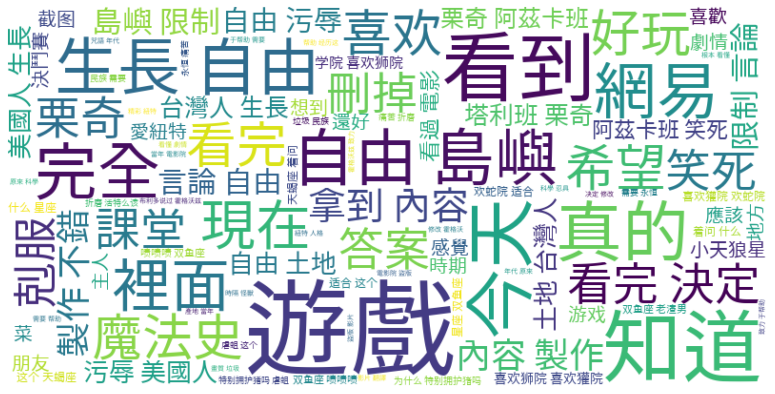

In [94]:

# 匯入自訂的 stop words (預設只有英文的)
stop_words_neg = stop_words
stop_words_neg.extend(('哈利波特','魔法覺醒','覺醒','玩'))
stop_words_neg = set(stop_words_neg)


# 設定中文字形
font_path = 'TaipeiSansTCBeta-Regular.ttf'

# 可以設定字型大小和背景顏色
wordcloud = WordCloud(
                stopwords=stop_words_neg,font_path=font_path,width=800, height = 400, max_words=100, background_color="white")\
                .generate(' '.join(negative_words['word']))

# Display the generated image:
plt.figure(figsize = (14,7))
plt.imshow(wordcloud, interpolation="bilinear")

plt.axis("off")
plt.show()

負面情緒多因此款遊戲為「中資」、「網易」主導而拒玩的相關討論貼文，也出現「限制」、「言論」，「台灣人」在自由島嶼等相關文字，另外也有網友不滿「刪掉」遊戲。

### 相關 code 參考
+ 相關文件
    + coreNLP
        + CoreNLPClient parameter
        + https://stanfordnlp.github.io/stanza/client_properties.html
    + tweetpy
        + API.search
        + https://docs.tweepy.org/en/v3.5.0/api.html#help-methods
        + API.search input output
        + https://developer.twitter.com/en/docs/twitter-api/v1/tweets/search/api-reference/get-search-tweets
        + search query rule
        + https://developer.twitter.com/en/docs/twitter-api/tweets/search/integrate/build-a-query
        + lang 抓取語言列表
        + https://developer.twitter.com/en/docs/twitter-for-websites/supported-languages
+ 參考code
    + 抓取twitter table
    + https://amandeepsaluja.com/getting-twitter-keyword-data-in-table-format-using-python/